# Temperature dependent elastic constants

## Background

$$C_{ijkl} = \frac{1}{V} \frac{\partial^2 U}{\partial \varepsilon_{ij}\partial \varepsilon_{kl}}$$

$$U(T) = \frac{V}{2}C_{ijkl}(T)\varepsilon_{ij}\varepsilon_{kl}$$

$$\sigma_{ij} = C_{ijkl}{\varepsilon_{kl}}$$

### How to get $U$ or $\sigma$

- MD
- Quasi-Harmonic

## Tasks

- Get $a_0$ from potential
- Lattice parameter (as a function of T)
  - MD
    - NVT
    - NPT
  - QH
- Calculate $U$ or $\sigma$ for various $\varepsilon$
  - MD: Equilibriate and average with LAMMPS
  - QH: Get strains from Yuriy's tool and run phonopy
- Fit

## Teams

- MD: Erik, Han, (Raynol), Prabhath, Jan
- QH: Raynol, (Sam), Bharathi, Ahmed, Haitham
- Fit & Yuriy: Sam
- Literature

# Implementation

* https://atomistics.readthedocs.io/en/latest/bulk_modulus_with_gpaw.html#elastic-matrix
* https://github.com/pyiron/atomistics/blob/main/tests/test_elastic_lammpslib_functional.py
* https://github.com/pyiron/pyiron_workflow_atomistics/blob/interstitials/pyiron_workflow_atomistics/dataclass_storage.py
* https://github.com/ligerzero-ai/pyiron_workflow_lammps/blob/main/pyiron_workflow_lammps/engine.py#L21

## Imports

In [1]:
from ase.build import bulk
from ase.atoms import Atoms

In [ ]:
import numpy as np
import pandas as pd

from atomistics.workflows.elastic.workflow import (
    analyse_structures_helper,
    generate_structures_helper,
)

from atomistics.calculators import evaluate_with_lammpslib, get_potential_by_name
from atomistics.calculators.lammps.libcalculator import calc_static_with_lammpslib
from atomistics.calculators import calc_molecular_dynamics_npt_with_lammpslib
from atomistics.calculators import calc_molecular_dynamics_nvt_with_lammpslib

## Create bulk sample

In [3]:
structure = bulk('Al', 'fcc', a=4.05, cubic=True)

In [4]:
potential_name = "1999--Mishin-Y--Al--LAMMPS--ipr1"

In [5]:
df_pot_selected = get_potential_by_name(
    potential_name=potential_name
)


/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst


## 0K Relaxed Structure

In [6]:
def get_relaxed_structure(structure: Atoms, potential: str) -> Atoms:
    
    df_pot_selected = get_potential_by_name(
            potential_name=potential
        )
    
    result_dict = evaluate_with_lammpslib(
            task_dict={"optimize_positions_and_volume": structure},
            potential_dataframe=df_pot_selected,
        )
    
    structure_relaxed = result_dict['structure_with_optimized_positions_and_volume']

    return structure_relaxed

In [7]:
relaxed_structure = get_relaxed_structure(structure, potential_name)
relaxed_structure

/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst
--------------------------------------------------------------------------

  Local host:   cmti001
  Local device: hfi1_0
--------------------------------------------------------------------------


Atoms(symbols='Al4', pbc=True, cell=[4.050004662201837, 4.050004662201837, 4.050004662201837])

## 0K Lattice Constant

In [8]:
def get_minimum_lattice_constant(structure: Atoms, potential: str) -> float:

    structure_relaxed = get_relaxed_structure(structure, potential)
    a_0 = structure_relaxed.get_volume()**(1/3) #Angstrom

    return a_0

In [9]:
a_0 = get_minimum_lattice_constant(structure, potential_name)
a_0

/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst


4.050004662201837

## 0K Elastic Constants

### Calculated individually

#### Calculate C11

In [12]:
from atomistics.calculators.lammps.libcalculator import calc_static_with_lammpslib

In [10]:
structure_strained = relaxed_structure.copy()

structure_strained.set_cell(
    [structure_strained.get_cell()[0]*(0.995), structure_strained.get_cell()[1], structure_strained.get_cell()[2]],
    scale_atoms=True
)

structure_strained

Atoms(symbols='Al4', pbc=True, cell=[4.029754638890828, 4.050004662201837, 4.050004662201837])

In [13]:
relaxed_dict = calc_static_with_lammpslib(structure=relaxed_structure, potential_dataframe= df_pot_selected)
strained_dict = calc_static_with_lammpslib(structure=structure_strained, potential_dataframe= df_pot_selected)

print("Relaxed stress:\n", relaxed_dict['stress'])
print("Strained stress:\n", strained_dict['stress'])

diff = strained_dict['stress'] - relaxed_dict['stress']
C11 = diff[0, 0] / 0.005
# C12 = diff[0, 1] / 0.005

C11

Relaxed stress:
 [[-2.43580132e-04  2.02497379e-11  2.52703340e-11]
 [ 2.02497379e-11 -2.43580106e-04  2.62291021e-11]
 [ 2.52703340e-11  2.62291021e-11 -2.43580114e-04]]
Strained stress:
 [[ 5.72921753e+03 -1.46328933e-11 -1.22781749e-11]
 [-1.46328933e-11  3.07529760e+03  2.34727955e-11]
 [-1.22781749e-11  2.34727955e-11  3.07529760e+03]]


1145843.555110171

#### Calculate C12

In [14]:
structure_strained = relaxed_structure.copy()

structure_strained.set_cell(
    [structure_strained.get_cell()[0]*(0.995), structure_strained.get_cell()[1]*(0.995), structure_strained.get_cell()[2]],
    scale_atoms=True
)

structure_strained

Atoms(symbols='Al4', pbc=True, cell=[4.029754638890828, 4.029754638890828, 4.050004662201837])

In [15]:
relaxed_dict = calc_static_with_lammpslib(structure=relaxed_structure, potential_dataframe= df_pot_selected)
strained_dict = calc_static_with_lammpslib(structure=structure_strained, potential_dataframe= df_pot_selected)

print("Relaxed stress:\n", relaxed_dict['stress'])
print("Strained stress:\n", strained_dict['stress'])

diff = strained_dict['stress'] - relaxed_dict['stress']
# C11 = diff[0, 0] / 0.005
# C12 = diff[0, 1] / 0.005

sigma11 = diff[0, 0]
sigma33 = diff[2, 2]

C12 = (sigma33/ 0.005) /2
C12

Relaxed stress:
 [[-2.43580132e-04  2.02497379e-11  2.52703340e-11]
 [ 2.02497379e-11 -2.43580106e-04  2.62291021e-11]
 [ 2.52703340e-11  2.62291021e-11 -2.43580114e-04]]
Strained stress:
 [[ 8.80299001e+03  1.47064255e-11 -2.02847248e-12]
 [ 1.47064255e-11  8.80299001e+03  7.45067521e-12]
 [-2.02847248e-12  7.45067521e-12  6.13579643e+03]]


613579.6671739953

In [16]:
sigma11/ 0.005 - C11

614754.4955247561

In [17]:
sigma22 = diff[1, 1]
sigma22/ 0.005 - C11

614754.4955247543

#### Calculate C44

In [18]:
relaxed_structure.get_volume()

66.43035441556098

In [19]:
relaxed_structure.get_cell().tolist()

[[4.050004662201837, 0.0, 0.0],
 [0.0, 4.050004662201837, 0.0],
 [0.0, 0.0, 4.050004662201837]]

In [20]:
structure_strained = relaxed_structure.copy()
relaxed_cell = np.array(structure_strained.get_cell().tolist())

F = np.eye(3,3) + np.array([
    [ 0, 0, 0],
    [ 0, 0, 0.0005],
    [ 0, 0.0005, 0]
])

strained_cell = F@relaxed_cell
print(strained_cell)

structure_strained.set_cell(
    strained_cell,
    scale_atoms=True
)

structure_strained

[[4.05000466e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.05000466e+00 2.02500233e-03]
 [0.00000000e+00 2.02500233e-03 4.05000466e+00]]


Atoms(symbols='Al4', pbc=True, cell=[[4.050004662201837, 0.0, 0.0], [0.0, 4.050004662201837, 0.0020250023311009185], [0.0, 0.0020250023311009185, 4.050004662201837]])

In [21]:
structure_strained.get_volume()

66.43033780797236

In [22]:
from structuretoolkit.visualize import plot3d

plot3d(structure_strained)

NGLWidget()

In [23]:
relaxed_dict = calc_static_with_lammpslib(structure=relaxed_structure, potential_dataframe= df_pot_selected)
strained_dict = calc_static_with_lammpslib(structure=structure_strained, potential_dataframe= df_pot_selected)

print("Relaxed stress:\n", relaxed_dict['stress'])
print("Strained stress:\n", strained_dict['stress'])

diff = strained_dict['stress'] - relaxed_dict['stress']
print("Stress difference:\n", diff)

sigma23 = diff[2, 1]

C44 = sigma23 / (2 *0.0005)
C44

Relaxed stress:
 [[-2.43580132e-04  2.02497379e-11  2.52703340e-11]
 [ 2.02497379e-11 -2.43580106e-04  2.62291021e-11]
 [ 2.52703340e-11  2.62291021e-11 -2.43580114e-04]]
Strained stress:
 [[ 4.10367247e-01 -3.37954779e-11 -1.97645834e-11]
 [-3.37954779e-11  3.47506713e-01 -3.15961812e+02]
 [-1.97645834e-11 -3.15961812e+02  3.47506713e-01]]
Stress difference:
 [[ 4.10610827e-01 -5.40452157e-11 -4.50349174e-11]
 [-5.40452157e-11  3.47750293e-01 -3.15961812e+02]
 [-4.50349174e-11 -3.15961812e+02  3.47750293e-01]]


/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/helpers.py:29: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  lmp.interactive_structure_setter(


-315961.8121188986

### Combined function

In [ ]:
def get_elastic_constant_after_deformation(structure : Atoms, potential_dataframe : pd.DataFrame, elastic_constant : str, deformation_gradient : np.array, strain : float):

    structure_strained = structure.copy()
    relaxed_cell = np.array(structure_strained.get_cell().tolist())

    strained_cell = deformation_gradient@relaxed_cell
    structure_strained.set_cell(strained_cell, scale_atoms=True)

    relaxed_dict = calc_static_with_lammpslib(structure=structure, potential_dataframe=potential_dataframe)
    strained_dict = calc_static_with_lammpslib(structure=structure_strained, potential_dataframe=potential_dataframe)

    # print("Relaxed stress:\n", relaxed_dict['stress'])
    # print("Strained stress:\n", strained_dict['stress'])

    diff = strained_dict['stress'] - relaxed_dict['stress']

    if elastic_constant == 'C11':
        constant = diff[0, 0] / strain

    elif elastic_constant == 'C12':
        sigma33 = diff[2, 2]
        constant = (sigma33/ strain) / 2

    elif elastic_constant == 'C44':
        sigma23 = diff[2, 1]
        constant = sigma23 / (2 * strain)

    return abs(constant)


In [25]:
def calculate_elastic_constants(structure : Atoms, potential : str, strain : float = 0.005) -> list:

    df_pot_selected = get_potential_by_name(
        potential_name=potential
    )

    elastic_constants_list = []

    deformation_gradient_dict = {
        'C11': np.eye(3,3) + np.array([[ strain,      0,      0], 
                                       [      0,      0,      0],
                                       [      0,      0,      0]]),
        'C12': np.eye(3,3) + np.array([[ strain,      0,      0], 
                                       [      0, strain,      0], 
                                       [      0,      0,      0]]),
        'C44': np.eye(3,3) + np.array([[      0,      0,      0], 
                                       [      0,      0, strain], 
                                       [      0, strain,      0]])
    }

    for constant_str, deformation_gradient in deformation_gradient_dict.items():
        const = get_elastic_constant_after_deformation(structure=structure, 
                                                       potential_dataframe=df_pot_selected, 
                                                       elastic_constant=constant_str, 
                                                       deformation_gradient=deformation_gradient,
                                                       strain=strain)
        elastic_constants_list.append(const)

    return elastic_constants_list

In [26]:
calculate_elastic_constants(structure=relaxed_structure, potential=potential_name, strain=-0.005)

/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst
/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/helpers.py:29: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  lmp.interactive_structure_setter(


[1145843.555110171, 613579.6671739953, 316998.27964768995]

## Finite Temperature Elastic Constants

### Equilibriated lattice constant
* First run NPT to relax volume
* Then equilibriate the cell by running NVT

#### NPT simulation

In [11]:
calc_molecular_dynamics_npt_with_lammpslib?

Signature:
calc_molecular_dynamics_npt_with_lammpslib(
    structure: 'Atoms',
    potential_dataframe: 'pandas.DataFrame',
    Tstart: 'float' = 100.0,
    Tstop: 'float' = 100.0,
    Tdamp: 'float' = 0.1,
    run: 'int' = 100,
    thermo: 'int' = 100,
    timestep: 'float' = 0.001,
    Pstart: 'float' = 0.0,
    Pstop: 'float' = 0.0,
    Pdamp: 'float' = 1.0,
    seed: 'int' = 4928459,
    dist: 'str' = 'gaussian',
    lmp=None,
    output_keys=('positions', 'cell', 'forces', 'temperature', 'energy_pot', 'energy_tot', 'pressure', 'velocities', 'volume'),
    **kwargs,
) -> 'dict'
Docstring: <no docstring>
File:      /cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/libcalculator.py
Type:      function

In [37]:
structure_repeated = relaxed_structure.repeat(5)

In [ ]:
npt_dict = calc_molecular_dynamics_npt_with_lammpslib(
    structure=structure_repeated,
    potential_dataframe=df_pot_selected,
    Tstart=500,
    Tstop=500,
    #Tdamp=,
    run=10000,
    thermo=100
)

In [21]:
npt_dict.keys()

dict_keys(['positions', 'cell', 'forces', 'temperature', 'energy_pot', 'energy_tot', 'pressure', 'velocities', 'volume'])

In [43]:
len(relaxed_structure)

4

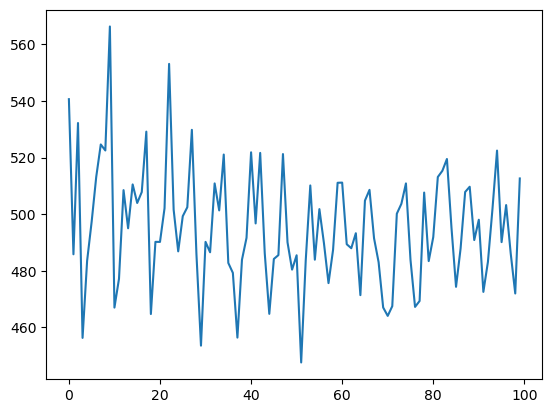

In [49]:
import matplotlib.pyplot as plt
plt.plot(npt_dict['temperature'])

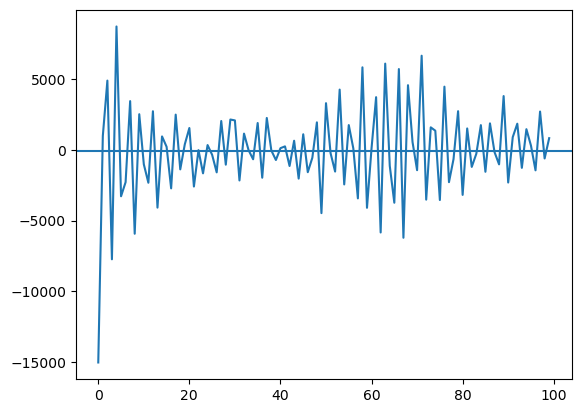

In [33]:
import matplotlib.pyplot as plt
plt.plot(npt_dict['pressure'][:,0,0])
plt.axhline(np.mean(npt_dict['pressure'][:,0,0]), linestyle='-')

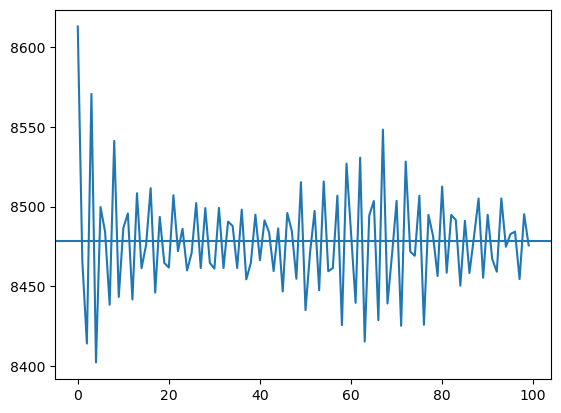

In [34]:
plt.plot(npt_dict['volume'])
plt.axhline(np.mean(npt_dict['volume']), linestyle='-')

Text(0.5, 0, 'Timesteps')

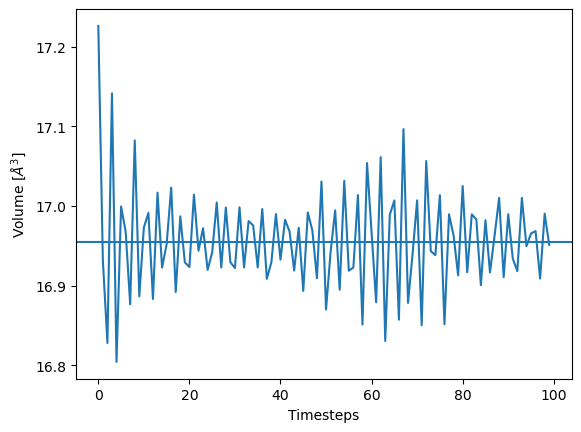

In [ ]:
plt.plot(npt_dict['volume']/len(structure_repeated))
plt.axhline(np.mean(npt_dict['volume'][20:]/len(structure_repeated)), linestyle='-')
plt.ylabel("Volume [$\AA^3$]")
plt.xlabel("Timesteps")

In [44]:
npt_lattice_constant = (np.mean(npt_dict['volume'][20:]/len(structure_repeated))*len(relaxed_structure))**(1/3)
npt_lattice_constant

4.078049083124835

#### NVT simulation

In [47]:
structure_repeated_npt = bulk('Al', a=npt_lattice_constant, cubic=True).repeat(5)

In [46]:
calc_molecular_dynamics_nvt_with_lammpslib?

Signature:
calc_molecular_dynamics_nvt_with_lammpslib(
    structure: 'Atoms',
    potential_dataframe: 'pandas.DataFrame',
    Tstart: 'float' = 100.0,
    Tstop: 'float' = 100.0,
    Tdamp: 'float' = 0.1,
    run: 'int' = 100,
    thermo: 'int' = 10,
    timestep: 'float' = 0.001,
    seed: 'int' = 4928459,
    dist: 'str' = 'gaussian',
    lmp=None,
    output_keys=('positions', 'cell', 'forces', 'temperature', 'energy_pot', 'energy_tot', 'pressure', 'velocities', 'volume'),
    **kwargs,
) -> 'dict'
Docstring: <no docstring>
File:      /cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/libcalculator.py
Type:      function

In [48]:
nvt_dict = calc_molecular_dynamics_nvt_with_lammpslib(
    structure=structure_repeated_npt,
    potential_dataframe=df_pot_selected,
    Tstart=500,
    Tstop=500,
    #Tdamp=,
    run=10000,
    thermo=100
)

In [51]:
nvt_dict.keys()

dict_keys(['positions', 'cell', 'forces', 'temperature', 'energy_pot', 'energy_tot', 'pressure', 'velocities', 'volume'])

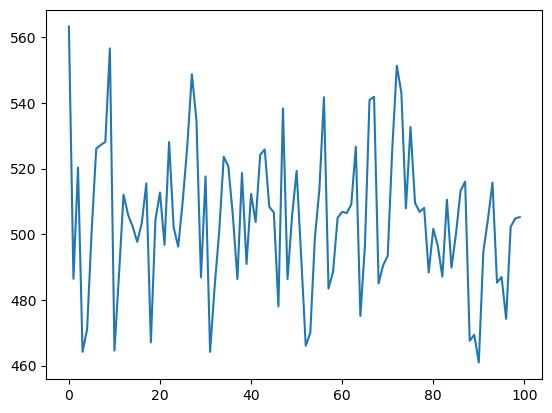

In [52]:
import matplotlib.pyplot as plt
plt.plot(nvt_dict['temperature'])

-48.646111103616185 bar


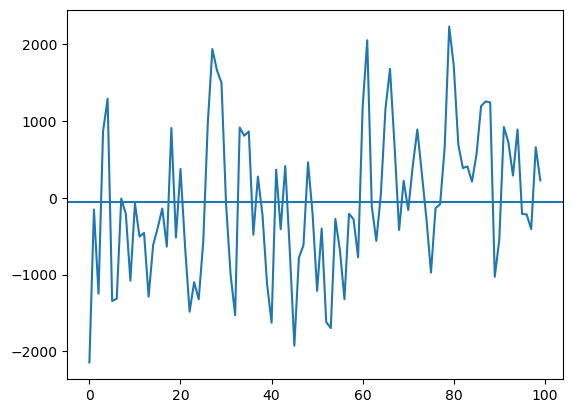

In [55]:
import matplotlib.pyplot as plt
plt.plot(nvt_dict['pressure'][:,0,0])
plt.axhline(np.mean(nvt_dict['pressure'][:,0,0]), linestyle='-')
print(np.mean(nvt_dict['pressure'][:,0,0]), "bar")

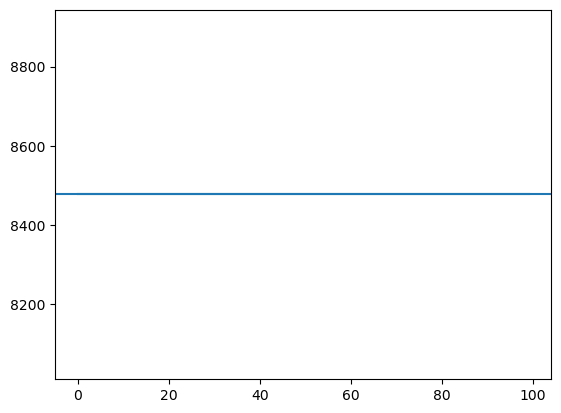

In [56]:
plt.plot(nvt_dict['volume'])
plt.axhline(np.mean(nvt_dict['volume']), linestyle='-')

In [59]:
structure_repeated_nvt = structure_repeated_npt.copy()
structure_repeated_nvt.set_cell(
    nvt_dict['cell'][-1]
)
structure_repeated_nvt.set_positions(
    nvt_dict['positions'][-1]
)
structure_repeated_nvt.set_velocities(
    nvt_dict['velocities'][-1]
)

### Combined function

In [98]:
def get_elastic_constant_after_deformation_at_finite_temperature(structure : Atoms, potential_dataframe : pd.DataFrame, elastic_constant : str, deformation_gradient : np.array, temperature : float, strain : float):

    from atomistics.calculators.lammps.libcalculator import calc_molecular_dynamics_nvt_with_lammpslib # FIXME: Add to top later!

    structure_strained = structure.copy()
    relaxed_cell = np.array(structure_strained.get_cell().tolist())

    strained_cell = deformation_gradient@relaxed_cell
    structure_strained.set_cell(strained_cell, scale_atoms=True)

    relaxed_dict = calc_molecular_dynamics_nvt_with_lammpslib(structure=structure, 
                                                              potential_dataframe=potential_dataframe,
                                                              Tstart=temperature,
                                                              Tstop=temperature,
                                                              run=10000,
                                                              thermo=100)
    strained_dict = calc_molecular_dynamics_nvt_with_lammpslib(structure=structure_strained, 
                                                              potential_dataframe=potential_dataframe,
                                                              Tstart=temperature,
                                                              Tstop=temperature,
                                                              run=10000,
                                                              thermo=100)

    # print("Relaxed stress:\n", relaxed_dict['pressure'])
    # print("Strained stress:\n", strained_dict['pressure'])

    diff = -np.mean(strained_dict['pressure'] - relaxed_dict['pressure'], axis=0)
    # print(diff)

    if elastic_constant == 'C11':
        constant = diff[0, 0] / strain

    elif elastic_constant == 'C12':
        sigma33 = diff[2, 2]
        constant = (sigma33/ strain) / 2

    elif elastic_constant == 'C44':
        sigma23 = diff[2, 1]
        constant = sigma23 / (2 * strain)

    return abs(constant)


In [94]:
def calculate_elastic_constants_at_finite_temperature(structure : Atoms, potential : str, temperature : float = 500, strain : float = 0.005) -> list:

    df_pot_selected = get_potential_by_name(
        potential_name=potential
    )

    elastic_constants_list = []

    deformation_gradient_dict = {
        'C11': np.eye(3,3) + np.array([[ strain,      0,      0], 
                                       [      0,      0,      0],
                                       [      0,      0,      0]]),
        'C12': np.eye(3,3) + np.array([[ strain,      0,      0], 
                                       [      0, strain,      0], 
                                       [      0,      0,      0]]),
        'C44': np.eye(3,3) + np.array([[      0,      0,      0], 
                                       [      0,      0, strain], 
                                       [      0, strain,      0]])
    }

    for constant_str, deformation_gradient in deformation_gradient_dict.items():
        const = get_elastic_constant_after_deformation_at_finite_temperature(structure=structure, 
                                                                                potential_dataframe=df_pot_selected, 
                                                                                elastic_constant=constant_str, 
                                                                                deformation_gradient=deformation_gradient,
                                                                                temperature=temperature,
                                                                                strain=strain)
        elastic_constants_list.append(const)

    return elastic_constants_list

In [ ]:
#FIXME: Need to have the equilibriated structures at each temperature
elastic_constants_list_300 = calculate_elastic_constants_at_finite_temperature(structure=structure_repeated_nvt, potential=potential_name, temperature=300, strain=0.005)
elastic_constants_list_500 = calculate_elastic_constants_at_finite_temperature(structure=structure_repeated_nvt, potential=potential_name, temperature=500, strain=0.005)
elastic_constants_list_800 = calculate_elastic_constants_at_finite_temperature(structure=structure_repeated_nvt, potential=potential_name, temperature=800, strain=0.005)

In [100]:
elastic_constants_list_300, elastic_constants_list_500, elastic_constants_list_800

([1050412.7057393359, 609492.9418437293, 309984.6744940177],
 [1051359.7459461081, 614919.3220086889, 314049.14973470924],
 [1060340.7532499686, 632094.4701107409, 274675.3496349924])

### Testing

In [73]:
df_pot_selected = get_potential_by_name(
        potential_name=potential_name
    )

elastic_constants_list = []
strain = 0.005
deformation_gradient_dict = {
    'C11': np.eye(3,3) + np.array([[ strain,      0,      0], 
                                    [      0,      0,      0],
                                    [      0,      0,      0]]),
    'C12': np.eye(3,3) + np.array([[ strain,      0,      0], 
                                    [      0, strain,      0], 
                                    [      0,      0,      0]]),
    'C44': np.eye(3,3) + np.array([[      0,      0,      0], 
                                    [      0,      0, strain], 
                                    [      0, strain,      0]])
}

# for constant_str, deformation_gradient in deformation_gradient_dict.items


/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst


In [88]:
structure_strained = structure_repeated_nvt.copy()
relaxed_cell = np.array(structure_strained.get_cell().tolist())

deformation_gradient = deformation_gradient_dict['C11']
temperature = 500

strained_cell = deformation_gradient@relaxed_cell
structure_strained.set_cell(strained_cell, scale_atoms=True)

relaxed_dict = calc_molecular_dynamics_nvt_with_lammpslib(structure=structure_repeated_nvt, 
                                                            potential_dataframe=df_pot_selected,
                                                            Tstart=temperature,
                                                            Tstop=temperature,
                                                            run=10000,
                                                            thermo=100)
strained_dict = calc_molecular_dynamics_nvt_with_lammpslib(structure=structure_strained, 
                                                            potential_dataframe=df_pot_selected,
                                                            Tstart=temperature,
                                                            Tstop=temperature,
                                                            run=10000,
                                                            thermo=100)

print("Relaxed stress:\n", relaxed_dict['pressure'])
print("Strained stress:\n", strained_dict['pressure'])

Relaxed stress:
 [[[ 7.28383848e+03  1.27396862e+03  2.33190656e+03]
  [ 1.27396862e+03  7.35349849e+03  1.44982364e+02]
  [ 2.33190656e+03  1.44982364e+02  7.42163145e+03]]

 [[ 4.06410485e+03  2.77845729e+02 -5.20632925e+02]
  [ 2.77845729e+02  7.00342474e+03 -6.94652984e+02]
  [-5.20632925e+02 -6.94652984e+02  5.16701889e+03]]

 [[ 1.28772099e+03  4.59249671e+02 -6.29626004e+01]
  [ 4.59249671e+02  2.40995503e+03  6.42472942e+02]
  [-6.29626004e+01  6.42472942e+02  1.07900233e+03]]

 [[-2.47117100e+01  5.18730804e+02 -2.03227319e+01]
  [ 5.18730804e+02  6.29206798e+01 -1.16718507e+03]
  [-2.03227319e+01 -1.16718507e+03  1.90372203e+02]]

 [[-1.96779427e+02  1.41833541e+03 -7.71623544e+02]
  [ 1.41833541e+03 -5.17996064e+02 -1.02074658e+03]
  [-7.71623544e+02 -1.02074658e+03 -4.80228335e+02]]

 [[-1.20237823e+03 -1.32164217e+02 -3.83579486e+02]
  [-1.32164217e+02 -6.75011516e+02  1.06265058e+03]
  [-3.83579486e+02  1.06265058e+03 -1.64698628e+03]]

 [[-2.31786023e+02 -2.10584627e+01 

In [89]:
relaxed_cell, strained_cell

(array([[20.39024542,  0.        ,  0.        ],
        [ 0.        , 20.39024542,  0.        ],
        [ 0.        ,  0.        , 20.39024542]]),
 array([[20.49219664,  0.        ,  0.        ],
        [ 0.        , 20.39024542,  0.        ],
        [ 0.        ,  0.        , 20.39024542]]))

In [90]:
np.mean(relaxed_dict['pressure'], axis=0), np.mean(strained_dict['pressure'], axis=0)

(array([[ 498.12242854,   43.73611369, -134.37839407],
        [  43.73611369,  454.72483838,    7.36318195],
        [-134.37839407,    7.36318195,  208.63312764]]),
 array([[-4758.67630119,     5.58326625,   -85.56030685],
        [    5.58326625, -2568.26822227,   232.37740429],
        [  -85.56030685,   232.37740429, -2834.81993244]]))

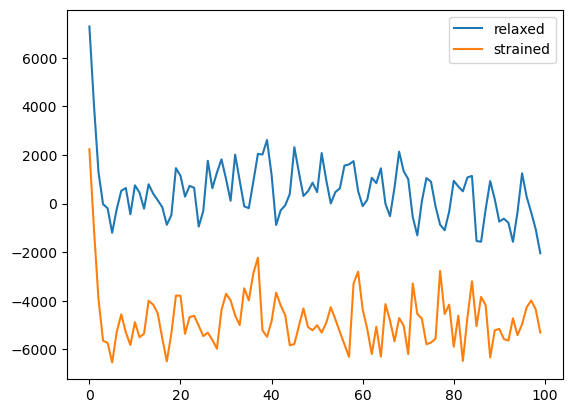

In [91]:
plt.plot(relaxed_dict['pressure'][:,0,0], label="relaxed")
plt.plot(strained_dict['pressure'][:,0,0], label="strained")
plt.legend()

In [ ]:
diff = -np.mean(strained_dict['pressure'][20:] - relaxed_dict['pressure'][20:], axis=0)
print(diff)

# if elastic_constant == 'C11':
constant = diff[0, 0] / strain
print(constant)
# elif elastic_constant == 'C12':
#     sigma33 = diff[2, 2]
#     constant = (sigma33/ strain) / 2

# elif elastic_constant == 'C44':
#     sigma23 = diff[2, 1]
#     constant = sigma23 / (2 * strain)

[[5256.1099663    44.96842995  -80.4077054 ]
 [  44.96842995 3032.75630109 -293.51458862]
 [ -80.4077054  -293.51458862 3032.70944648]]
1051221.9932606055


## Function to fit elastic constants

In [27]:
from atomistics.calculators.lammps.libcalculator import calc_static_with_lammpslib

In [29]:
sym_dict, structure_dict = generate_structures_helper(
    structure=relaxed_structure,
    eps_range=0.005,
    num_of_point=5,
    zero_strain_job_name="s_e_0",
    sqrt_eta=True,
)
structure_dict

/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/workflows/elastic/symmetry.py:32: DeprecationWarning: dict interface is deprecated. Use attribute interface instead
  SGN = dataset["number"]


OrderedDict([('s_e_0',
              Atoms(symbols='Al4', pbc=True, cell=[4.050004662201837, 4.050004662201837, 4.050004662201837])),
             ('s_01_e_m0_00500',
              Atoms(symbols='Al4', pbc=True, cell=[4.0297037591141, 4.0297037591141, 4.0297037591141])),
             ('s_01_e_m0_00250',
              Atoms(symbols='Al4', pbc=True, cell=[4.039866962542076, 4.039866962542076, 4.039866962542076])),
             ('s_01_e_0_00250',
              Atoms(symbols='Al4', pbc=True, cell=[4.060117049134704, 4.060117049134704, 4.060117049134704])),
             ('s_01_e_0_00500',
              Atoms(symbols='Al4', pbc=True, cell=[4.07020431200885, 4.07020431200885, 4.07020431200885])),
             ('s_08_e_m0_00500',
              Atoms(symbols='Al4', pbc=True, cell=[4.0297037591141, 4.0297037591141, 4.050004662201837])),
             ('s_08_e_m0_00250',
              Atoms(symbols='Al4', pbc=True, cell=[4.039866962542076, 4.039866962542076, 4.050004662201837])),
             ('s_

In [32]:
df_pot_selected = get_potential_by_name(
    potential_name=potential_name
)

result_dict = evaluate_with_lammpslib(
    task_dict={"calc_energy": structure_dict},
    potential_dataframe=df_pot_selected,
)

sym_dict, elastic_dict = analyse_structures_helper(
    output_dict=result_dict,
    sym_dict=sym_dict,
    fit_order=2,
    zero_strain_job_name="s_e_0",
)

sym_dict, elastic_dict

/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst
/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/helpers.py:29: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  lmp.interactive_structure_setter(


({'SGN': 225,
  'v0': 66.43035441556098,
  'LC': 'CI',
  'Lag_strain_list': ['01', '08', '23'],
  'epss': array([-0.005 , -0.0025,  0.    ,  0.0025,  0.005 ]),
  'strain_energy': [[(-0.005, -13.436320248980278),
    (-0.0025, -13.439079680886989),
    (0.0, -13.439999952735112),
    (0.0024999999999999996, -13.439084974614394),
    (0.005, -13.436364320399795)],
   [(-0.005, -13.43817471490433),
    (-0.0025, -13.439544638502635),
    (0.0, -13.439999952735112),
    (0.0024999999999999996, -13.43954822781134),
    (0.005, -13.43820419261515)],
   [(-0.005, -13.437971451918393),
    (-0.0025, -13.439501038418326),
    (0.0, -13.439999952735112),
    (0.0024999999999999996, -13.439515785430654),
    (0.005, -13.438089441277945)]],
  'e0': -13.439999952735112,
  'A2': array([2.20130388, 1.08985578, 1.1861949 ])},
 {'elastic_matrix': array([[114.103117  ,  60.51102935,  60.51102935,   0.        ,
            0.        ,   0.        ],
         [ 60.51102935, 114.103117  ,  60.51102935,   0

In [52]:
def fit_elastic_constants(structure: Atoms, potential: str, strains, stresses=None, energies=None):

    sym_dict, structure_dict = generate_structures_helper(
        structure=structure,
        eps_range=0.005,
        num_of_point=5,
        zero_strain_job_name="s_e_0",
        sqrt_eta=True,
    )

    df_pot_selected = get_potential_by_name(
        potential_name=potential
    )

    result_dict = evaluate_with_lammpslib(
        task_dict={"calc_energy": structure_dict},
        potential_dataframe=df_pot_selected,
    )

    sym_dict, elastic_dict = analyse_structures_helper(
        output_dict=result_dict,
        sym_dict=sym_dict,
        fit_order=2,
        zero_strain_job_name="s_e_0",
    )

    return elastic_dict

In [53]:
relaxed_structure = get_relaxed_structure(structure, potential_name)
elast_dict = fit_elastic_constants(
    structure=relaxed_structure,
    potential=potential_name,
    strains=None)
elast_dict['elastic_matrix']

/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst
/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/workflows/elastic/symmetry.py:32: DeprecationWarning: dict interface is deprecated. Use attribute interface instead
  SGN = dataset["number"]
/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

array([[114.103117  ,  60.51102935,  60.51102935,   0.        ,
          0.        ,   0.        ],
       [ 60.51102935, 114.103117  ,  60.51102935,   0.        ,
          0.        ,   0.        ],
       [ 60.51102935,  60.51102935, 114.103117  ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,  31.67489592,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         31.67489592,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,  31.67489592]])

In [ ]:
def get_bulk_structure(
    name: str,
    crystalstructure=None,
    a=None,
    b=None,
    c=None,
    alpha=None,
    covera=None,
    u=None,
    orthorhombic=False,
    cubic=False,
    basis=None,
):
    from ase.build import bulk
    equil_struct = bulk(
        name=name,
        crystalstructure=crystalstructure,
        a=a,
        b=b,
        c=c,
        alpha=alpha,
        covera=covera,
        u=u,
        orthorhombic=orthorhombic,
        cubic=cubic,
        basis=basis,
    )
    return equil_struct